In [1]:
from __future__ import print_function
from keras.layers import  Input, LSTM,Dense,Dropout
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model, Model
from keras.layers import Embedding
import cPickle as pickle
from matplotlib import pyplot
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import ModelCheckpoint
from keras import regularizers
import psutil

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
psutil.virtual_memory()

svmem(total=8240283648, available=5272322048, percent=36.0, used=2463342592, free=3402358784, active=3214114816, inactive=1365135360, buffers=725307392, cached=1649274880, shared=238923776)

In [3]:
#FN1='embeddingReviewsFilewithOtherdata'
FN2='myPaddedDataFile'

In [4]:
with open('%s.pkl'%FN2,'rb') as fp:
    embeddingReviews, modiefiedSummaryWord_index,myPaddedData= pickle.load(fp)

In [5]:
psutil.virtual_memory()

svmem(total=8240283648, available=5242023936, percent=36.4, used=2493640704, free=3372060672, active=3270201344, inactive=1338785792, buffers=725331968, cached=1649250304, shared=238923776)

In [6]:
paddedReviews=myPaddedData['paddedReviews']
paddedSummary=myPaddedData['paddedSummary']
paddedModifiedSummary=myPaddedData['paddedModifiedSummary']
testPaddedReviews=myPaddedData['testPaddedReviews']
testPaddedSummary=myPaddedData['testPaddedSummary']

In [7]:
TrainingDataIX=paddedReviews
TrainingDataTY=paddedSummary
TrainingDataIY=paddedModifiedSummary
TrainingDataIX.shape,TrainingDataIY.shape,TrainingDataTY.shape

((1150, 400), (1150, 40), (1150, 40))

In [8]:
TestDataIX=testPaddedReviews
TestDataTY=testPaddedSummary

In [9]:
psutil.virtual_memory()

svmem(total=8240283648, available=5241278464, percent=36.4, used=2494373888, free=3371266048, active=3270791168, inactive=1338593280, buffers=725372928, cached=1649270784, shared=238923776)

In [10]:
nb_samples=len(TrainingDataIX)
nb_samples

1150

In [11]:
ModifiedVocabSize=len(modiefiedSummaryWord_index)


In [12]:
ModifiedVocabSize

6023

In [13]:
psutil.virtual_memory()

svmem(total=8240283648, available=5239406592, percent=36.4, used=2496147456, free=3369172992, active=3272024064, inactive=1338773504, buffers=725659648, cached=1649303552, shared=238923776)

In [14]:
decoderInputSummary=to_categorical(paddedModifiedSummary,num_classes=ModifiedVocabSize)

In [15]:
decoderInputSummary=decoderInputSummary.reshape(nb_samples,-1,ModifiedVocabSize)

In [16]:
decoderInputSummary.shape

(1150, 40, 6023)

In [17]:
psutil.virtual_memory()

svmem(total=8240283648, available=5055418368, percent=38.6, used=2681806848, free=3185070080, active=3454480384, inactive=1337245696, buffers=725692416, cached=1647714304, shared=237355008)

In [18]:
decoderTargetSummary=to_categorical(paddedSummary,num_classes=ModifiedVocabSize)

In [19]:
decoderTargetSummary.shape

(1150, 40, 6023)

In [20]:
decoderTargetSummary=decoderTargetSummary.reshape(nb_samples,-1,ModifiedVocabSize)

In [21]:
decoderTargetSummary.shape

(1150, 40, 6023)

In [22]:
psutil.virtual_memory()

svmem(total=8240283648, available=4862971904, percent=41.0, used=2874261504, free=2992566272, active=3642580992, inactive=1337253888, buffers=725741568, cached=1647714304, shared=237355008)

In [23]:
with open('%s.pkl'%'embeddingReviewsFile', 'rb') as fp:
    embeddingReviews = pickle.load(fp)

In [24]:
embedding_dim=100

In [25]:
ReviewsVocabSize=30171#39119#30172#27789
maxReviewLength=400#300
maxSummaryLength=40

In [26]:
#Encoder
EncoderEmbeddingLayer = Embedding(ReviewsVocabSize,
                            embedding_dim,
                            weights=[embeddingReviews],
                            input_length=maxReviewLength,
                            trainable=True,
                            #mask_zero=True
                                   )
encoderInputLayer=Input(shape=(maxReviewLength,))
print('encoder_input shape is:->',encoderInputLayer.shape)
embedded_Encoder_inputSequence=EncoderEmbeddingLayer(encoderInputLayer)
encoderLSTMLayer=LSTM(256,return_state=True)
#print(type(encoder_LSTM))
encoderOutput,encoderHState,encoderCState=encoderLSTMLayer(embedded_Encoder_inputSequence)
#print('encoder_output shape:->',encoder_output.shape)
encoderStates=[encoderHState,encoderCState]

encoder_input shape is:-> (?, 400)


In [27]:
decoderInputLayer=Input(shape=(None,ModifiedVocabSize))
#embedded_Decoder_inputSequence=Decoder_embedding_layer(decoder_input)
decoderLSTMLayer=LSTM(256,return_sequences=True, return_state = True,)
decoderOutput,decoderHState,decoderCState=decoderLSTMLayer(decoderInputLayer,initial_state=encoderStates)
decoderDenseLayer=Dense(ModifiedVocabSize,activation='softmax',kernel_regularizer=regularizers.l2(0.015))
finalDecoderOutput=decoderDenseLayer(decoderOutput)
#finalDecoderOutput=Dropout(0.25)(finalDecoderOutput)

In [28]:
model=Model(inputs=[encoderInputLayer,decoderInputLayer],output=finalDecoderOutput)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=[<tf.Tenso...)`
  """Entry point for launching an IPython kernel.


In [29]:
model.load_weights('AbstractiveTextSummarization1.hdf5')

In [30]:
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999,decay=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='AbstractiveTextSummarization2.2.hdf5', verbose=1, save_best_only=False,mode='auto',period=1)


In [30]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 100)     3017100     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 6023)   0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 256), (None, 365568      embedding_1[0][0]                
__________________________________________________________________________________________________
lstm_2 (LS

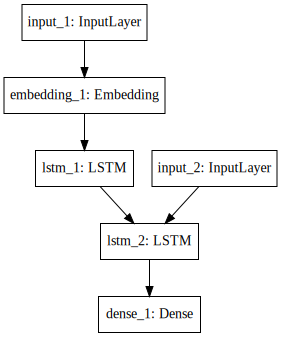

In [31]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [33]:
history=model.fit(x=[TrainingDataIX,decoderInputSummary], 
          y=decoderTargetSummary,
          batch_size=64,
          epochs=500,
          validation_split=0.2,callbacks=[checkpointer])

Train on 1600 samples, validate on 400 samples
Epoch 1/500
1600/1600 [==============================] - 250s 156ms/step - loss: 13.9392 - acc: 0.1516 - val_loss: 11.9526 - val_acc: 0.4601

Epoch 00001: saving model to AbstractiveTextSummarization2.2.hdf5


/usr/local/lib/python2.7/dist-packages/keras/engine/topology.py:2368: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_1/while/Exit_2:0' shape=(?, 128) dtype=float32>, <tf.Tensor 'lstm_1/while/Exit_3:0' shape=(?, 128) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


Epoch 2/500
1600/1600 [==============================] - 249s 156ms/step - loss: 13.2093 - acc: 0.3545 - val_loss: 11.3606 - val_acc: 0.4603

Epoch 00002: saving model to AbstractiveTextSummarization2.2.hdf5
Epoch 3/500
1600/1600 [==============================] - 256s 160ms/step - loss: 12.6991 - acc: 0.3573 - val_loss: 10.9102 - val_acc: 0.4601

Epoch 00003: saving model to AbstractiveTextSummarization2.2.hdf5
Epoch 4/500
1600/1600 [==============================] - 269s 168ms/step - loss: 12.2531 - acc: 0.3573 - val_loss: 10.3156 - val_acc: 0.4598

Epoch 00004: saving model to AbstractiveTextSummarization2.2.hdf5
Epoch 5/500
1600/1600 [==============================] - 270s 169ms/step - loss: 11.7202 - acc: 0.3570 - val_loss: 9.7858 - val_acc: 0.4591

Epoch 00005: saving model to AbstractiveTextSummarization2.2.hdf5
Epoch 6/500
1600/1600 [==============================] - 273s 171ms/step - loss: 11.3507 - acc: 0.3550 - val_loss: 9.4178 - val_acc: 0.4591

Epoch 00006: saving model to


Epoch 00041: saving model to AbstractiveTextSummarization2.2.hdf5
Epoch 42/500
1600/1600 [==============================] - 300s 187ms/step - loss: 8.4831 - acc: 0.3566 - val_loss: 6.2032 - val_acc: 0.4591

Epoch 00042: saving model to AbstractiveTextSummarization2.2.hdf5
Epoch 43/500
1600/1600 [==============================] - 267s 167ms/step - loss: 8.4734 - acc: 0.3565 - val_loss: 6.1828 - val_acc: 0.4591

Epoch 00043: saving model to AbstractiveTextSummarization2.2.hdf5
Epoch 44/500
1600/1600 [==============================] - 267s 167ms/step - loss: 8.4886 - acc: 0.3559 - val_loss: 6.1632 - val_acc: 0.4591

Epoch 00044: saving model to AbstractiveTextSummarization2.2.hdf5
Epoch 45/500
1600/1600 [==============================] - 273s 171ms/step - loss: 8.4634 - acc: 0.3569 - val_loss: 6.1442 - val_acc: 0.4591

Epoch 00045: saving model to AbstractiveTextSummarization2.2.hdf5
Epoch 46/500
1600/1600 [==============================] - 273s 170ms/step - loss: 8.4715 - acc: 0.3547 - 


Epoch 00120: saving model to AbstractiveTextSummarization2.2.hdf5
Epoch 121/500
1600/1600 [==============================] - 281s 176ms/step - loss: 7.9772 - acc: 0.3550 - val_loss: 5.4831 - val_acc: 0.4591

Epoch 00121: saving model to AbstractiveTextSummarization2.2.hdf5
Epoch 122/500
1600/1600 [==============================] - 278s 173ms/step - loss: 7.9120 - acc: 0.3579 - val_loss: 5.4788 - val_acc: 0.4591

Epoch 00122: saving model to AbstractiveTextSummarization2.2.hdf5
Epoch 123/500
1600/1600 [==============================] - 275s 172ms/step - loss: 7.9385 - acc: 0.3563 - val_loss: 5.4744 - val_acc: 0.4591

Epoch 00123: saving model to AbstractiveTextSummarization2.2.hdf5
Epoch 124/500
1600/1600 [==============================] - 273s 171ms/step - loss: 7.8956 - acc: 0.3592 - val_loss: 5.4701 - val_acc: 0.4591

Epoch 00124: saving model to AbstractiveTextSummarization2.2.hdf5
Epoch 125/500
1600/1600 [==============================] - 271s 169ms/step - loss: 7.8827 - acc: 0.35

1600/1600 [==============================] - 257s 161ms/step - loss: 7.8168 - acc: 0.3570 - val_loss: 5.3419 - val_acc: 0.4591

Epoch 00160: saving model to AbstractiveTextSummarization2.2.hdf5
Epoch 161/500
1600/1600 [==============================] - 257s 161ms/step - loss: 7.8264 - acc: 0.3571 - val_loss: 5.3389 - val_acc: 0.4591

Epoch 00161: saving model to AbstractiveTextSummarization2.2.hdf5
Epoch 162/500
1600/1600 [==============================] - 256s 160ms/step - loss: 7.8340 - acc: 0.3553 - val_loss: 5.3359 - val_acc: 0.4591

Epoch 00162: saving model to AbstractiveTextSummarization2.2.hdf5
Epoch 163/500
1600/1600 [==============================] - 257s 161ms/step - loss: 7.8369 - acc: 0.3576 - val_loss: 5.3330 - val_acc: 0.4591

Epoch 00163: saving model to AbstractiveTextSummarization2.2.hdf5
Epoch 164/500
1600/1600 [==============================] - 259s 162ms/step - loss: 7.8131 - acc: 0.3570 - val_loss: 5.3301 - val_acc: 0.4591

Epoch 00164: saving model to Abstractive

1600/1600 [==============================] - 259s 162ms/step - loss: 7.6823 - acc: 0.3564 - val_loss: 5.1647 - val_acc: 0.4591

Epoch 00238: saving model to AbstractiveTextSummarization2.2.hdf5
Epoch 239/500
1600/1600 [==============================] - 257s 161ms/step - loss: 7.7107 - acc: 0.3549 - val_loss: 5.1630 - val_acc: 0.4591

Epoch 00239: saving model to AbstractiveTextSummarization2.2.hdf5
Epoch 240/500
1600/1600 [==============================] - 257s 160ms/step - loss: 7.6987 - acc: 0.3560 - val_loss: 5.1613 - val_acc: 0.4591

Epoch 00240: saving model to AbstractiveTextSummarization2.2.hdf5
Epoch 241/500
1600/1600 [==============================] - 259s 162ms/step - loss: 7.7078 - acc: 0.3561 - val_loss: 5.1596 - val_acc: 0.4591

Epoch 00241: saving model to AbstractiveTextSummarization2.2.hdf5
Epoch 242/500
1600/1600 [==============================] - 259s 162ms/step - loss: 7.6764 - acc: 0.3578 - val_loss: 5.1579 - val_acc: 0.4591

Epoch 00242: saving model to Abstractive

1600/1600 [==============================] - 280s 175ms/step - loss: 7.5715 - acc: 0.3580 - val_loss: 5.0535 - val_acc: 0.4591

Epoch 00316: saving model to AbstractiveTextSummarization2.2.hdf5
Epoch 317/500
1600/1600 [==============================] - 279s 174ms/step - loss: 7.6286 - acc: 0.3548 - val_loss: 5.0524 - val_acc: 0.4591

Epoch 00317: saving model to AbstractiveTextSummarization2.2.hdf5
Epoch 318/500
1600/1600 [==============================] - 280s 175ms/step - loss: 7.5747 - acc: 0.3585 - val_loss: 5.0512 - val_acc: 0.4591

Epoch 00318: saving model to AbstractiveTextSummarization2.2.hdf5
Epoch 319/500
1600/1600 [==============================] - 281s 175ms/step - loss: 7.6169 - acc: 0.3566 - val_loss: 5.0500 - val_acc: 0.4591

Epoch 00319: saving model to AbstractiveTextSummarization2.2.hdf5
Epoch 320/500
1600/1600 [==============================] - 280s 175ms/step - loss: 7.6010 - acc: 0.3565 - val_loss: 5.0489 - val_acc: 0.4591

Epoch 00320: saving model to Abstractive

1600/1600 [==============================] - 280s 175ms/step - loss: 7.5484 - acc: 0.3560 - val_loss: 4.9748 - val_acc: 0.4591

Epoch 00394: saving model to AbstractiveTextSummarization2.2.hdf5
Epoch 395/500
1600/1600 [==============================] - 280s 175ms/step - loss: 7.5614 - acc: 0.3558 - val_loss: 4.9740 - val_acc: 0.4591

Epoch 00395: saving model to AbstractiveTextSummarization2.2.hdf5
Epoch 396/500
1600/1600 [==============================] - 281s 176ms/step - loss: 7.5351 - acc: 0.3567 - val_loss: 4.9731 - val_acc: 0.4591

Epoch 00396: saving model to AbstractiveTextSummarization2.2.hdf5
Epoch 397/500
1600/1600 [==============================] - 279s 175ms/step - loss: 7.5524 - acc: 0.3572 - val_loss: 4.9723 - val_acc: 0.4591

Epoch 00397: saving model to AbstractiveTextSummarization2.2.hdf5
Epoch 398/500
1600/1600 [==============================] - 278s 174ms/step - loss: 7.5881 - acc: 0.3547 - val_loss: 4.9715 - val_acc: 0.4591

Epoch 00398: saving model to Abstractive

1600/1600 [==============================] - 269s 168ms/step - loss: 7.5007 - acc: 0.3562 - val_loss: 4.9173 - val_acc: 0.4591

Epoch 00472: saving model to AbstractiveTextSummarization2.2.hdf5
Epoch 473/500
1600/1600 [==============================] - 262s 164ms/step - loss: 7.5097 - acc: 0.3554 - val_loss: 4.9167 - val_acc: 0.4591

Epoch 00473: saving model to AbstractiveTextSummarization2.2.hdf5
Epoch 474/500
1600/1600 [==============================] - 265s 166ms/step - loss: 7.4813 - acc: 0.3583 - val_loss: 4.9161 - val_acc: 0.4591

Epoch 00474: saving model to AbstractiveTextSummarization2.2.hdf5
Epoch 475/500
1600/1600 [==============================] - 261s 163ms/step - loss: 7.5187 - acc: 0.3554 - val_loss: 4.9154 - val_acc: 0.4591

Epoch 00475: saving model to AbstractiveTextSummarization2.2.hdf5
Epoch 476/500
1600/1600 [==============================] - 262s 163ms/step - loss: 7.4918 - acc: 0.3568 - val_loss: 4.9148 - val_acc: 0.4591

Epoch 00476: saving model to Abstractive

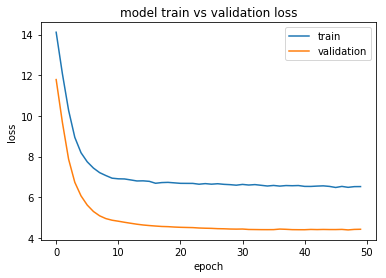

In [34]:
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

# Inferencing

In [32]:
encoderModelInference=Model(inputs=encoderInputLayer,outputs=encoderStates)

In [33]:
DecoderInputStateH=Input(shape=(256,))
DecoderInputStateC = Input(shape=(256,))
DecoderInputStates = [DecoderInputStateH, DecoderInputStateC]
decoderOutput,decoderHState,decoderCState = decoderLSTMLayer(decoderInputLayer,initial_state=DecoderInputStates)
decoderStates=[decoderHState,decoderCState]
decoderInferenceFinalOutput = decoderDenseLayer(decoderOutput)
decoderModelInf = Model(inputs=[decoderInputLayer] + DecoderInputStates,
                          outputs=[decoderInferenceFinalOutput] + decoderStates )

In [34]:
modiefiedSummaryWord_index['SOS']

6021

In [35]:
int_to_vocab_summaries = {}
for word, value in modiefiedSummaryWord_index.items():
    int_to_vocab_summaries[value] = word

In [36]:
def generateSummary(inputReview):
    # Initial states value is coming from the encoder 
    #We get the encoder states into encoderStatesVar variable
    encoderStatesVar = encoderModelInference.predict(inputReview)#return encoder states
    targetSummary = np.zeros((1,1,ModifiedVocabSize))
    print('targetSummary shape:->',targetSummary.shape)
    targetSummary[0, 0, modiefiedSummaryWord_index['SOS']] = 1
    print(targetSummary.shape)
    #targetSummary=embeddingModifiedSummaries[modiefiedSummaryWord_index['SOS']]
    summarized_sent = ''
    stop = False
    i=1
    while not stop:
        decoderOutput,decoderHState,decoderCState = decoderModelInf.predict(x=[targetSummary] + encoderStatesVar)
        #print(decoder_out)
        maxValIndex = np.argmax(decoderOutput[0,-1,:])
        sampledSummaryWord = int_to_vocab_summaries[maxValIndex]
        #print('sampledSummaryWord is:->',sampledSummaryWord)
        #print()
        summarized_sent += sampledSummaryWord+" "
        #print('summarized_sent is:->',summarized_sent)
        #print()
        if ((sampledSummaryWord == 'EOS') or (len(summarized_sent) >= maxSummaryLength)) :
            print('terminated')
            stop = True
        
        targetSummary = np.zeros((1,1,ModifiedVocabSize))
        targetSummary[0, 0, maxValIndex]=1
        
        encoderStatesVar  = [decoderHState,decoderCState]
        i=i+1
        
    return summarized_sent

In [37]:
import numpy as np

In [38]:
human_summary=[]
for i in range(50):    
    #print('System Generated Summary:',summary)
    temp=[]
    for j in range(len(testPaddedSummary[i])):
        temp.append(int_to_vocab_summaries[testPaddedSummary[i][j]])
    human_summary.append(temp)    
humanSummary=" "        
for i in range(50):
    data=testPaddedReviews[i].reshape(1,400)
    summary=generateSummary(data)
    print('System Generated Summary:',summary)
    for j in range(len(human_summary[i])):
        humanSummary+=human_summary[i][j]+" "
    print('Human Summary',humanSummary)
    humanSummary=" "

targetSummary shape:-> (1, 1, 6023)
(1, 1, 6023)
terminated
System Generated Summary: the sleek kate kate and do but it is still 
Human Summary  tragic and haunting a beautifully heartwrenching portrait of child abandonment PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD 
targetSummary shape:-> (1, 1, 6023)
(1, 1, 6023)
terminated
System Generated Summary: though it is not much this comic and offers 
Human Summary  it might be thinly written and messily made but gainsbourg a heroic life is also appropriately glamorous and intense and powerfully led by a gripping performance from erik elmosnino PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD 
targetSummary shape:-> (1, 1, 6023)
(1, 1, 6023)
terminated
System Generated Summary: a raw entertaining family drama with ultimately 
Human Summary  faithful to its literary source this is imaginative intelligent family entertainment PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD

targetSummary shape:-> (1, 1, 6023)
(1, 1, 6023)
terminated
System Generated Summary: a powerful documentarylike examination of 
Human Summary  overblown in the best sense of the word francis ford coppolas vision of bram stokers dracula rescues the character from decades of campy interpretations and features some terrific performances to boot PAD PAD PAD PAD PAD PAD PAD PAD PAD 
targetSummary shape:-> (1, 1, 6023)
(1, 1, 6023)
terminated
System Generated Summary: a powerful and meticulous in this farmiga 
Human Summary  magic trip is overall unenlightening though there is an inherent novelty and joy in seeing the unearthed footage of ken kesey and his band of merry pranksters PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD 
targetSummary shape:-> (1, 1, 6023)
(1, 1, 6023)
terminated
System Generated Summary: a powerful and fails to this the movie that 
Human Summary  francis ford coppolas haunting hallucinatory vietnam war epic is cinema at its most audacious and visionary PAD PAD 

In [39]:
from nltk.translate.bleu_score import sentence_bleu

In [43]:
humanSummary=" "  
scores=[]
for i in range(1,50):
    data=testPaddedReviews[i].reshape(1,400)
    summary=generateSummary(data)
    print('System Generated Summary:',summary)
    for j in range(len(human_summary[i])):
        humanSummary+=human_summary[i][j]+" "
    print('Human Summary',humanSummary)
    #calculation of bleu score
    score=sentence_bleu(summary,humanSummary,weights=(0.5, 0.5, 0, 0))
    print('BlEU SCORE IS:->',score)
    scores.append(score)      
    humanSummary=" "

total=0
for i in scores:
    total+=i
print('AVERAGE BLEU SCORE:->',total/len(scores))

targetSummary shape:-> (1, 1, 6023)
(1, 1, 6023)
terminated
System Generated Summary: though it is not much this comic and offers 
Human Summary  it might be thinly written and messily made but gainsbourg a heroic life is also appropriately glamorous and intense and powerfully led by a gripping performance from erik elmosnino PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD 
BlEU SCORE IS:-> 0.26548932464
targetSummary shape:-> (1, 1, 6023)
(1, 1, 6023)
terminated
System Generated Summary: a raw entertaining family drama with ultimately 
Human Summary  faithful to its literary source this is imaginative intelligent family entertainment PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD 
BlEU SCORE IS:-> 0.263262095056
targetSummary shape:-> (1, 1, 6023)
(1, 1, 6023)
terminated
System Generated Summary: a powerful documentarylike of the cinema 
Human Summary  campy charm and a knowing sense of humor help to overcome a silly plo

terminated
System Generated Summary: although on a gripping performance from 
Human Summary  the final film by the great robert altman a prairie home companion the big screen adaptation of garrison keillors radio broadcast showcases plenty of the directors strengths it is got a gigantic cast and plenty of quirky acting and dialogue 
BlEU SCORE IS:-> 0.257129738613
targetSummary shape:-> (1, 1, 6023)
(1, 1, 6023)
terminated
System Generated Summary: a powerful documentarylike examination of 
Human Summary  a manic overstuffed blend of scifi comedy and romance innerspace nonetheless charms thanks to martin shorts fine performance and the insistent zaniness of the plot PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD 
BlEU SCORE IS:-> 0.274873708375
targetSummary shape:-> (1, 1, 6023)
(1, 1, 6023)
terminated
System Generated Summary: a powerful documentarylike examination of 
Human Summary  overblown in the best sense of the word francis ford coppolas vision of bram stokers dra

terminated
System Generated Summary: though of a good cast with a innocence drama 
Human Summary  a creepy thriller that poses more questions than it answers PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD 
BlEU SCORE IS:-> 0.278115203285
targetSummary shape:-> (1, 1, 6023)
(1, 1, 6023)
terminated
System Generated Summary: despite the plot of the year of steve cumberbatch 
Human Summary  competent but somewhat static tristan isolde does not achieve the sweeping romanticism that it aims for PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD 
BlEU SCORE IS:-> 0.299252800832
targetSummary shape:-> (1, 1, 6023)
(1, 1, 6023)
terminated
System Generated Summary: clever and and is stylish with its musical 
Human Summary  the dances in rize are electric even if the documentary does not go that deeply into the performers lives PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD P